Dataset Shape: (1600, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gyro_x   1600 non-null   float64
 1   gyro_y   1600 non-null   float64
 2   gyro_z   1600 non-null   float64
 3   accel_x  1600 non-null   float64
 4   accel_y  1600 non-null   float64
 5   accel_z  1600 non-null   float64
 6   flipped  1600 non-null   float64
dtypes: float64(7)
memory usage: 87.6 KB
None

Class Distribution:
flipped
0.0    800
1.0    800
Name: count, dtype: int64

First few rows:
      gyro_x     gyro_y     gyro_z   accel_x   accel_y   accel_z  flipped
0   7.450712  14.074257  -3.657929 -0.216521  0.055553  0.827301      0.0
1  -2.073965  -7.740671  27.497528  0.053046  0.127633  0.993759      0.0
2   9.715328   1.441812 -12.919284 -0.164004  0.066687  1.003603      0.0
3  22.845448  -6.934129 -15.983840 -0.081497  0.383660  1.094526      0.0
4 

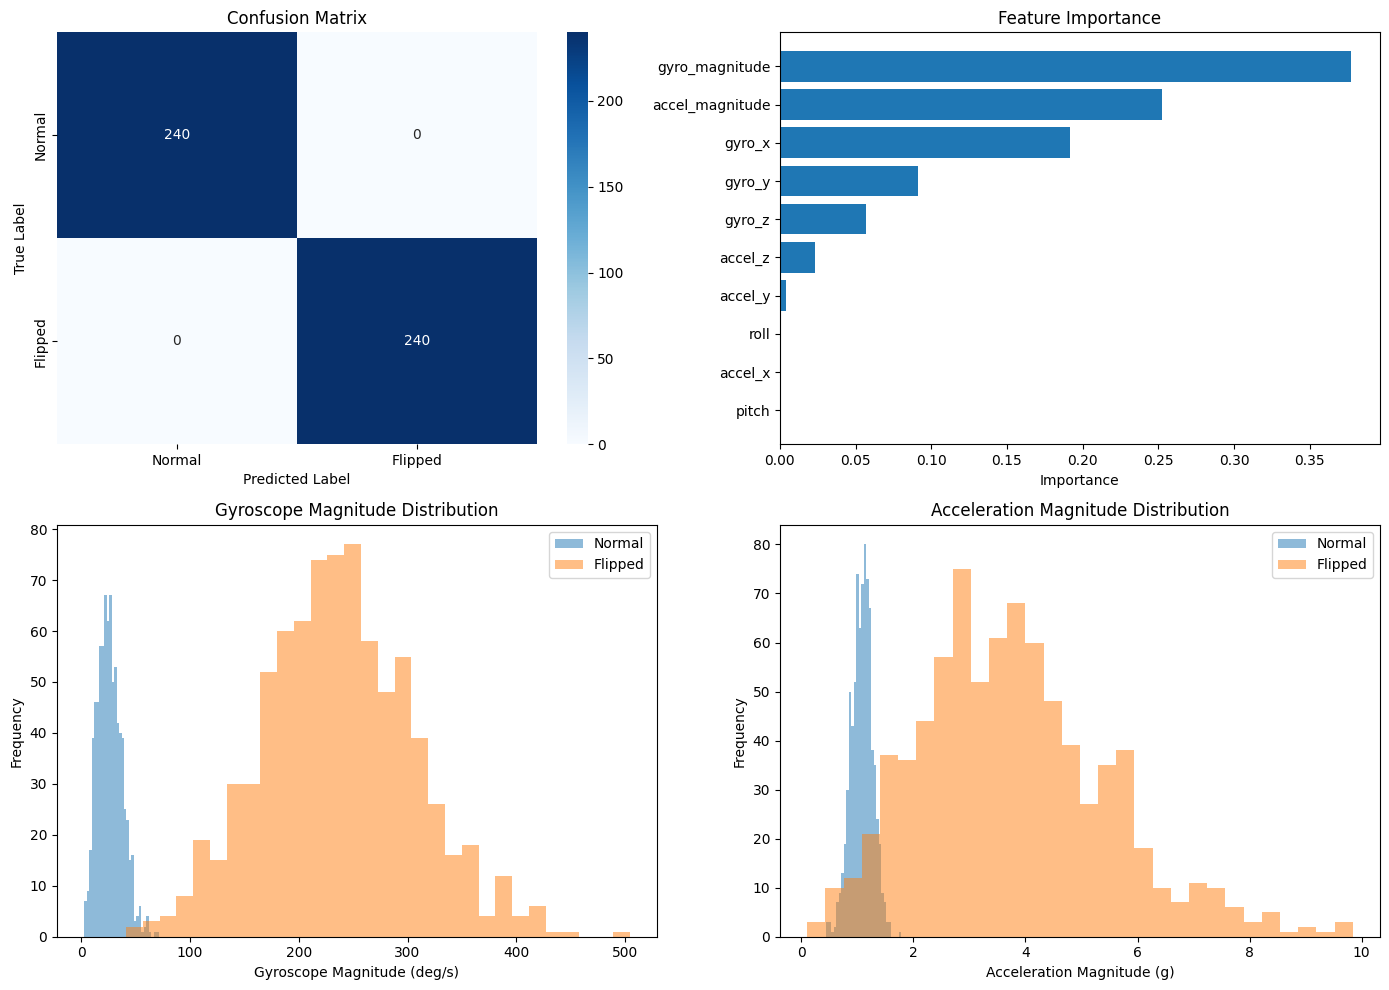


TESTING WITH NEW SAMPLES

Test 1 - Normal Driving:
Prediction: NORMAL
Confidence: Normal=100.00%, Flipped=0.00%

Test 2 - Car Flipping:
Prediction: FLIPPED
Confidence: Normal=0.00%, Flipped=100.00%

Model saved as 'car_flip_rf_model.pkl'
Scaler saved as 'car_flip_scaler.pkl'


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# STEP 1: Generate Synthetic MPU6050 Gyroscope Data
# ============================================================================
# In real scenario, replace this with actual MPU6050 sensor readings
# MPU6050 provides: gyro_x, gyro_y, gyro_z (angular velocity in deg/s)
#                   accel_x, accel_y, accel_z (acceleration in g)

np.random.seed(42)

def generate_normal_driving_data(n_samples=500):
    """Simulate normal driving - small variations"""
    gyro_x = np.random.normal(0, 15, n_samples)  # Small rotations
    gyro_y = np.random.normal(0, 15, n_samples)
    gyro_z = np.random.normal(0, 20, n_samples)  # Turning

    accel_x = np.random.normal(0, 0.3, n_samples)  # Small lateral accel
    accel_y = np.random.normal(0, 0.3, n_samples)
    accel_z = np.random.normal(1.0, 0.2, n_samples)  # ~1g downward

    labels = np.zeros(n_samples)  # 0 = Normal
    return gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, labels

def generate_flip_data(n_samples=500):
    """Simulate car flipping - high angular velocity and erratic acceleration"""
    gyro_x = np.random.normal(150, 80, n_samples)  # High rotation
    gyro_y = np.random.normal(120, 70, n_samples)
    gyro_z = np.random.normal(100, 60, n_samples)

    accel_x = np.random.normal(0, 2.5, n_samples)  # High g-forces
    accel_y = np.random.normal(0, 2.5, n_samples)
    accel_z = np.random.normal(0, 2.0, n_samples)  # Erratic vertical

    labels = np.ones(n_samples)  # 1 = Flipped
    return gyro_x, gyro_y, gyro_z, accel_x, accel_y, accel_z, labels

# Generate datasets
normal_data = generate_normal_driving_data(800)
flip_data = generate_flip_data(800)

# Combine data
gyro_x = np.concatenate([normal_data[0], flip_data[0]])
gyro_y = np.concatenate([normal_data[1], flip_data[1]])
gyro_z = np.concatenate([normal_data[2], flip_data[2]])
accel_x = np.concatenate([normal_data[3], flip_data[3]])
accel_y = np.concatenate([normal_data[4], flip_data[4]])
accel_z = np.concatenate([normal_data[5], flip_data[5]])
labels = np.concatenate([normal_data[6], flip_data[6]])

# Create DataFrame
df = pd.DataFrame({
    'gyro_x': gyro_x,
    'gyro_y': gyro_y,
    'gyro_z': gyro_z,
    'accel_x': accel_x,
    'accel_y': accel_y,
    'accel_z': accel_z,
    'flipped': labels
})

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nClass Distribution:")
print(df['flipped'].value_counts())
print("\nFirst few rows:")
print(df.head())

# ============================================================================
# STEP 2: Feature Engineering
# ============================================================================

# Add magnitude features
df['gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)
df['accel_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)

# Add tilt angle (pitch and roll estimation)
df['pitch'] = np.arctan2(df['accel_y'], np.sqrt(df['accel_x']**2 + df['accel_z']**2)) * 180/np.pi
df['roll'] = np.arctan2(df['accel_x'], np.sqrt(df['accel_y']**2 + df['accel_z']**2)) * 180/np.pi

print("\nFeatures after engineering:")
print(df.columns.tolist())

# ============================================================================
# STEP 3: Prepare Data for Training
# ============================================================================

# Select features
features = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z',
            'gyro_magnitude', 'accel_magnitude', 'pitch', 'roll']

X = df[features]
y = df['flipped']

# Split data: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ============================================================================
# STEP 4: Train Random Forest Classifier
# ============================================================================

rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum tree depth
    min_samples_split=5,     # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

print("\nTraining Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("Training complete!")

# ============================================================================
# STEP 5: Evaluate Model
# ============================================================================

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Flipped']))

# ============================================================================
# STEP 6: Feature Importance
# ============================================================================

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# ============================================================================
# STEP 7: Visualizations
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Normal', 'Flipped'], yticklabels=['Normal', 'Flipped'])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Feature Importance
axes[0, 1].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Feature Importance')
axes[0, 1].invert_yaxis()

# Gyroscope Magnitude Distribution
axes[1, 0].hist(df[df['flipped']==0]['gyro_magnitude'], alpha=0.5, label='Normal', bins=30)
axes[1, 0].hist(df[df['flipped']==1]['gyro_magnitude'], alpha=0.5, label='Flipped', bins=30)
axes[1, 0].set_xlabel('Gyroscope Magnitude (deg/s)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Gyroscope Magnitude Distribution')
axes[1, 0].legend()

# Acceleration Magnitude Distribution
axes[1, 1].hist(df[df['flipped']==0]['accel_magnitude'], alpha=0.5, label='Normal', bins=30)
axes[1, 1].hist(df[df['flipped']==1]['accel_magnitude'], alpha=0.5, label='Flipped', bins=30)
axes[1, 1].set_xlabel('Acceleration Magnitude (g)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Acceleration Magnitude Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('car_flip_detection_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'car_flip_detection_analysis.png'")
plt.show()

# ============================================================================
# STEP 8: Test with New Sample Data
# ============================================================================

print("\n" + "="*60)
print("TESTING WITH NEW SAMPLES")
print("="*60)

# Test sample 1: Normal driving
test_normal = np.array([[5, -3, 10, 0.1, -0.05, 1.0,
                         np.sqrt(5**2 + 3**2 + 10**2),
                         np.sqrt(0.1**2 + 0.05**2 + 1.0**2),
                         0, 0]])
test_normal_scaled = scaler.transform(test_normal)
pred_normal = rf_model.predict(test_normal_scaled)
prob_normal = rf_model.predict_proba(test_normal_scaled)

print("\nTest 1 - Normal Driving:")
print(f"Prediction: {'FLIPPED' if pred_normal[0] == 1 else 'NORMAL'}")
print(f"Confidence: Normal={prob_normal[0][0]:.2%}, Flipped={prob_normal[0][1]:.2%}")

# Test sample 2: Flipped car
test_flipped = np.array([[180, 150, 120, 2.0, -2.5, 0.3,
                          np.sqrt(180**2 + 150**2 + 120**2),
                          np.sqrt(2.0**2 + 2.5**2 + 0.3**2),
                          45, -30]])
test_flipped_scaled = scaler.transform(test_flipped)
pred_flipped = rf_model.predict(test_flipped_scaled)
prob_flipped = rf_model.predict_proba(test_flipped_scaled)

print("\nTest 2 - Car Flipping:")
print(f"Prediction: {'FLIPPED' if pred_flipped[0] == 1 else 'NORMAL'}")
print(f"Confidence: Normal={prob_flipped[0][0]:.2%}, Flipped={prob_flipped[0][1]:.2%}")

# ============================================================================
# STEP 9: Save Model (optional)
# ============================================================================

import pickle

# Save model and scaler
with open('car_flip_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('car_flip_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n" + "="*60)
print("Model saved as 'car_flip_rf_model.pkl'")
print("Scaler saved as 'car_flip_scaler.pkl'")
print("="*60)